In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import manifold
import pickle as pk
from sklearn import linear_model
import time
from skl_groups.features import Features
from skl_groups.summaries import BagOfWords
from sklearn.cluster import KMeans
from sklearn.cross_validation import KFold
from mpl_toolkits.axes_grid1 import *
from sklearn.manifold import LocallyLinearEmbedding
import seaborn as sns
import scipy
from skl_groups.kernels import PairwisePicker, Symmetrize, RBFize, ProjectPSD

%matplotlib inline

In [35]:
# load kernel file
def loadSimilarities(fn):
    """
    Load the previously saved similarity matrix from a .npz file

    Inputs:
    - fn: directory/filename (minus extension) to load the file from

    Returns:
    - loadedSims: similarity matrix
    """
    loader = np.load(fn+".npz")
    print "Similarities loaded!"
    return loader['similarities']

kernelFN = "./simulatedData/kernel-2000-sym-v2"
kernelFN = "./simulatedData/kernel-2000-sym-pix-kl"
kl_sym = loadSimilarities(kernelFN)
# kernelFN = "./simulatedData/kernel-2000-sym-he"
kernelFN = "./simulatedData/kernel-2000-sym-pix-he"
he_sym = loadSimilarities(kernelFN)

# Note: loaded kernel is the result of
# - building the KNN graph using KL divergence
# - symmeterizing the graph: KL is not a distance and is not symmetric, we need distance-symmetry behavior because next step is...
# - passing the symmeterized graph through a radial basis function (RBF): Since the value of the RBF kernel decreases with distance and ranges between zero (in the limit) and one (when x = x'), it has a ready interpretation as a similarity measure
# - projecting the output of the RBF to a positive semi-definite space: 

Similarities loaded!
Similarities loaded!


0.99987 1.0 1.00048


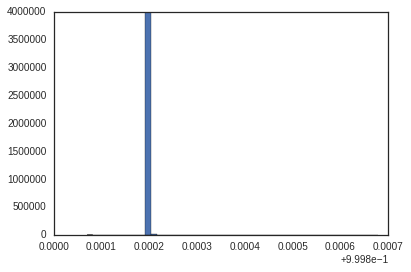

In [36]:
print he_sym.min(), np.median(he_sym.flatten()), he_sym.max()
_ = plt.hist(he_sym.flatten(),50)

0.0 0.792604 1.0
0.367527 0.367878 0.367975


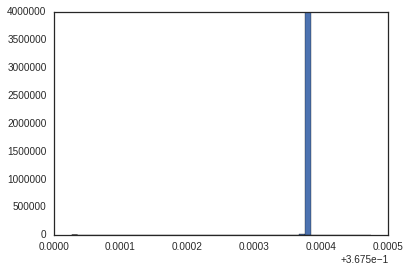

In [22]:
assert (kl_sym == kl_sym.T).all()
assert (he_sym == he_sym.T).all()
rbf = RBFize(gamma=1, scale_by_median=True)
kl_rbf = rbf.fit_transform(kl_sym)
# rbf = RBFize(gamma=1.2, scale_by_median=False)
he_rbf = rbf.fit_transform(he_sym)
print kl_rbf.min(), np.median(kl_rbf), kl_rbf.max()
print he_rbf.min(), np.median(he_rbf), he_rbf.max()
_ = plt.hist(he_rbf.flatten(),50)

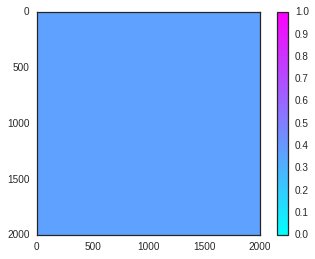

In [23]:
plt.imshow(he_rbf, vmin=0.0, vmax=1.0, cmap='cool')
plt.colorbar()

In [24]:
psd = ProjectPSD()
kernelKL = psd.fit_transform(kl_rbf)
kernelHE = psd.fit_transform(he_rbf)

In [37]:
kernelKL = kl_sym
kernelHE = he_sym

This is some information the projected kernel :
min, median, max value of the kernel: -0.300114 0.00480447 6.61104
less than 0.3 :0.908595
less than 0.5 :0.914262
less than 1.0 :0.9892175
-----------
number of subject with at least one entry higher than 1: 2000
These are diagonal elements: [ 3.72044659  4.19830084  4.64491081 ...,  5.50999451  4.78183508
  4.75891972]


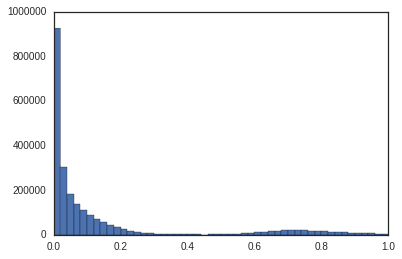

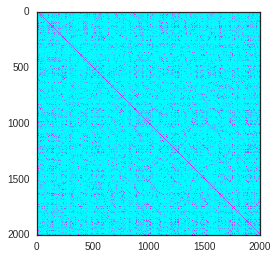

In [38]:
# Numerical checking
print "This is some information the projected kernel :"
print "min, median, max value of the kernel: " + str(np.min(kernelKL)) + " " + str(np.median(kernelKL)) +" "+ str(np.max(kernelKL))
print "less than 0.3 :" + str(np.sum(kernelKL.flatten() < 0.3)/np.float(np.prod(kernelKL.shape)))
print "less than 0.5 :" + str(np.sum(kernelKL.flatten() < 0.5)/np.float(np.prod(kernelKL.shape)))
print "less than 1.0 :" + str(np.sum(kernelKL.flatten() < 1)/np.float(np.prod(kernelKL.shape)))
print "-----------"
print "number of subject with at least one entry higher than 1: " + str( ((kernelKL > 1.0).sum(axis=0)>0).sum())
print "These are diagonal elements: " + str(np.diag(kernelKL))

plt.figure()
# _ = plt.hist(kernel.flatten()[:],50)
_ = plt.hist(kernelKL.flatten()[np.logical_and(kernelKL.flatten() < 1 , kernelKL.flatten() > 0) ],50)


plt.figure()
# plt.imshow(kernel, cmap='cool')
plt.imshow(kernelKL, vmin=0, vmax=1.0, cmap='cool')

This is some information the projected kernel (hellinger):
min, median, max value of the kernel: 0.99987 1.0 1.00048
less than 0.3 :0.908595
less than 0.5 :0.914262
less than 1.0 :0.9892175
-----------
number of subject with at least one entry higher than 1: 2000
These are diagonal elements: [ 1.0000006   1.00047815  1.00013661 ...,  1.00000155  1.00000155
  1.00000155]


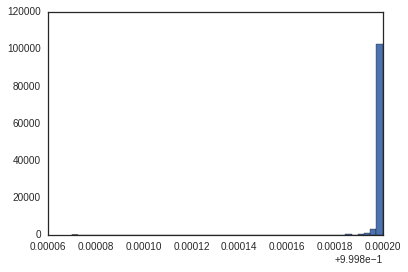

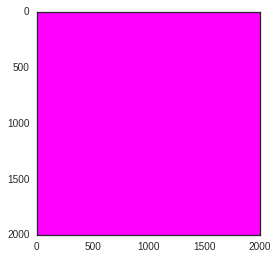

In [39]:
# Numerical checking
print "This is some information the projected kernel (hellinger):"
print "min, median, max value of the kernel: " + str(np.min(kernelHE)) + " " + str(np.median(kernelHE)) +" "+ str(np.max(kernelHE))
print "less than 0.3 :" + str(np.sum(kernelKL.flatten() < 0.3)/np.float(np.prod(kernelHE.shape)))
print "less than 0.5 :" + str(np.sum(kernelKL.flatten() < 0.5)/np.float(np.prod(kernelHE.shape)))
print "less than 1.0 :" + str(np.sum(kernelKL.flatten() < 1)/np.float(np.prod(kernelHE.shape)))
print "-----------"
print "number of subject with at least one entry higher than 1: " + str( ((kernelHE > 1.0).sum(axis=0)>0).sum())
print "These are diagonal elements: " + str(np.diag(kernelHE))

plt.figure()
# _ = plt.hist(kernel.flatten()[:],50)
_ = plt.hist(kernelHE.flatten()[np.logical_and(kernelHE.flatten() < 1 , kernelHE.flatten() > 0) ],50)


plt.figure()
# plt.imshow(kernel, cmap='cool')
plt.imshow(kernelHE, vmin=0, vmax=1.0, cmap='cool')

In [40]:
# cholesky factorization

# ============== cholesky
# K_PSD is the result of projection -> loaded kernel data
regParam =  1e-3
# perform the cholesky factorization
hidimKL = np.linalg.cholesky(kernelKL+(regParam*np.eye(kernelKL.shape[0])))
hidimHE = np.linalg.cholesky(kernelHE+(regParam*np.eye(kernelHE.shape[0])))

In [41]:
# =================== embedding for patient
# transform the cholesky factorization into a set of 2D features to use in the visualization
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)  # 
tSNEKL = tsne.fit_transform(hidimKL)   # hidim is the cholesky factorization
tSNEHE = tsne.fit_transform(hidimHE)

#clf = LocallyLinearEmbedding(n_c omponents=d)
#tSNE = clf.fit_transform(hidim)    

# plot 2d embedding

In [42]:
def loadSimSubjects(fn):
    """
    Load a previously saved simulated subject from a .npz file.

    Inputs:
    - fn: filename/directory to load from (extensionless)

    Returns:
    - features: single patient's features/nodes
    - ids: subject ids
    - y: the label (number of abnormal nodes)
    """
    with open(fn+"-feats.data.p", "rb") as f:
        loader = pk.load(f)
    f.close()
    print "Simluated patient features and metadata loaded!"
    return loader['ids'], np.asarray(loader['y']), loader['features']

# load the list of the number of abnormal nodes for each subject
patientsFN = "./simulatedData/simulatedSubjects"
ids, subjClasses, subjFeatures = loadSimSubjects(patientsFN)
# get a list of permuted indices to use - not necessary?
permIdx = np.random.permutation(range(len(ids)))
subjClasses_subset = np.array(subjClasses)[permIdx[:3000]]    
tSNEKL_subset = tSNEKL[permIdx[:3000]]
tSNEHE_subset = tSNEHE[permIdx[:3000]]


Simluated patient features and metadata loaded!


In [43]:
print subjClasses_subset.shape
print type(subjClasses_subset)

(2000,)
<type 'numpy.ndarray'>


In [44]:
def  plotLowDimWithColor( nodes2D, subjColor, 
                         ax=None, plotTitle=None, markerSize=2 ):
    """
    plot low dimensional embedding
    
    Inputs:
    - nodes2D: subset of patients that came from a higher dimensional space and need to be plotted in 2D for visualization
    - subjColor: number of abnormal nodes in each simulated patient
    
    Returns: nothing
    Effect: plots a scatter plot
    """
    inFeature = nodes2D

    # normalize the colors to a good range
    maxVal = -np.sort(-np.asarray(subjColor))[0]
    minVal = np.sort(np.asarray(subjColor))[0]
    cm = plt.cm.get_cmap('RdYlBu_r')
    print subjColor
    
    if ax==None:
        scatter(inFeature[:,0], inFeature[:,1], c=subjColor, 
                lw = 0, vmin=minVal, vmax=maxVal,  
                cmap=cm, s=markerSize )
        colorbar()
        plt.xlim(np.percentile(inFeature[:,0], 1, axis=0), 
                 np.percentile(inFeature[:,0], 99, axis=0))
        plt.ylim(np.percentile(inFeature[:,1], 1, axis=0), 
                 np.percentile(inFeature[:,1], 99, axis=0))   
        plt.title(plotTitle)      
    else:
        scPlot = ax.scatter(inFeature[:,0], inFeature[:,1], c=np.asarray(subjColor), 
                lw = 0, vmin=minVal, vmax=maxVal,  
                cmap=cm, s=markerSize  )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scPlot, cax=cax)
        ax.set_xlim(np.percentile(inFeature[:,0], 1, axis=0), 
                 np.percentile(inFeature[:,0], 99, axis=0))
        ax.set_ylim(np.percentile(inFeature[:,1], 1, axis=0), 
                 np.percentile(inFeature[:,1], 99, axis=0)) 
        ax.set_title(plotTitle)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

[ 367.29251331   38.8918154   372.10705662 ...,  120.10532748  159.38359515
  354.19001758]
(2000,)
<type 'numpy.ndarray'>


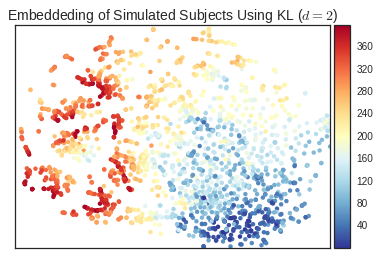

In [70]:
with sns.axes_style("white"):
    f, ax1 = plt.subplots()

# write your own visualizationb, each subject is a dot in 2D and color each subject with her own y
plotLowDimWithColor(tSNEKL_subset, subjClasses_subset, 
                    ax=ax1, plotTitle='', markerSize=20)

ax1.set_xlim([-22,16])
ax1.set_ylim([-24,14])
ax1.set_title('Embeddeding of Simulated Subjects Using KL ($d=2$)',fontsize=14)
f.savefig("tsne-kl-pix.pdf")
print subjClasses_subset.shape
print type(subjClasses_subset)

[ 367.29251331   38.8918154   372.10705662 ...,  120.10532748  159.38359515
  354.19001758]


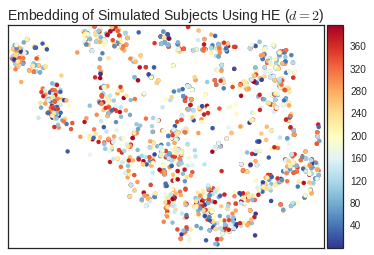

In [69]:
with sns.axes_style("white"):
    f, ax1 = plt.subplots()

# write your own visualizationb, each subject is a dot in 2D and color each subject with her own y
plotLowDimWithColor(tSNEHE_subset, subjClasses_subset, 
                    ax=ax1, plotTitle='tSNE', markerSize=20)

ax1.set_xlim([-16,16])
ax1.set_ylim([-6,14])
ax1.set_title('Embedding of Simulated Subjects Using HE ($d=2$)',fontsize=14)

f.savefig("tsne-he-pix.pdf")

In [72]:
# ========== extracting higher dim features per subject
clf = LocallyLinearEmbedding(n_components=100)
LLE_modified_KL = clf.fit_transform(hidimKL)   # this is your X, ie your feature per subject
LLE_modified_HE = clf.fit_transform(hidimHE)

print LLE_modified_KL.shape
print LLE_modified_HE.shape

(2000, 100)
(2000, 100)


In [71]:
# ======== Regression
numPCA_comp = 60
colNameList = []
for numDim in range(2,numPCA_comp,4):
    colNameList.append(['LLE_modified_f%d'%i for i in range(numDim)])

score_r2DictList = {}
p_r2DictList = {}
accScoreDictList = {}
p_accDictList = {}    
    
featureName = 'histFHOG_largeRange_setting1'
score_r2DictList[featureName] = []
p_r2DictList[featureName] = []
accScoreDictList[featureName] = []
p_accDictList[featureName] = []

print len(colNameList)

15


In [18]:
# Helper functions
def evalFeatures_Regression(XTrain,yTrain,XTest,yTest,m):
    """
    evaluate a regression model
    """

    # scaling
    stdScaler = StandardScaler()
    stdScaler.fit(XTrain)
    XTrain = stdScaler.transform(XTrain)
    yTrain = np.log10(yTrain)
    XTest = stdScaler.transform(XTest)
    yTest = np.log10(yTest)
        
    m.fit(XTrain, yTrain)
    pred_y = m.predict(XTest)
    r2 = metrics.r2_score(yTest, pred_y)
    s = metrics.mean_squared_error(yTest, pred_y)
    return r2, s, pred_y

In [25]:
for colName in colNameList:
    #---------------------  Compute BOW
    t0 = time.clock()
    print "computing bag of words ......"
    feats = Features(subjFeatures)      # here the data is your patient patch data - list of patch features
    bow = BagOfWords(KMeans(n_clusters=len(colName), max_iter=100, n_init=2))
    bowized = bow.fit_transform(feats)
    print "Bag of words computed!"
    print time.time() - t0
    
    X_KL = LLE_modified_KL[:,:len(colName)]
    X_HE = LLE_modified_HE[:,:len(colName)]
    
    print "Shape of bow: " + str(bowized.shape)
    print "Column name: " + str(colName)
    print "Len(colName): " + str(len(colName))
    print "X.shape: " + str(X_KL.shape)
    print "X HE: " + str(X_HE.shape)

    # make a cross-validation object
    cv = KFold(n=len(subjClasses), n_folds=50, shuffle=False, random_state=0)

    ### regression
    allXy = {}    
    yName = 'FEV1pp_utah'    

    
#     allXy['SimulatedNNFeats'] = (X,y)
#     allXy['BOW'] = (bowized,y)
    y = np.asarray(subjClasses)  # loaded earlier as the number of abnormal nodes in the subject
    allXy['Ours-KL'] = (X_KL, y)   # lle_modified
    allXy['Ours-HE'] = (X_HE, y)
    allXy['BOW'] = (bowized, y)    # replaced y with subjList


    score_r2Dict = {}
    p_r2Dict = {}
    for k in allXy.keys():         
        #clf = linear_model.Ridge(alpha=1)
        score_r2Dict[k] = [] 
        #score_r2Dict[k] = cross_val_score(clf, allXy[k][0], allXy[k][1], cv=50, scoring='r2_score')
        print "working on ",k, "...."
        for i, (train, test) in enumerate(cv):
            clf = linear_model.Ridge(alpha=1)
            r2,s,pred = evalFeatures_Regression(allXy[k][0][train],    # your X (LLE_modified)
                                           allXy[k][1][train],    # your y 
                                           allXy[k][0][test],     # your X
                                           allXy[k][1][test],clf) # your y
            score_r2Dict[k].append(r2)

    # add the results to a list
    score_r2DictList[featureName].append(score_r2Dict)
#     p_r2DictList[featureName].append(p_r2Dict)
#     accScoreDictList[featureName].append(accScoreDict)
#     p_accDictList[featureName].append(p_accDict)
    

resultsRoot = './simulatedData/evaluation'
pk.dump( score_r2DictList, open(resultsRoot + "/linReg_score_r2DictList_v2.p",'wb') )
# pk.dump( p_r2DictList, open(resultsRoot + "/linReg_p_r2DictList.p",'wb') )
# pk.dump( accScoreDictList, open(hellingerRoot + "/linReg_accScoreDictList.p",'wb') )
# pk.dump( p_accDictList, open(hellingerRoot + "/linReg_p_accDictList.p",'wb') )

computing bag of words ......
Bag of words computed!
1481313629.6
Shape of bow: (2000, 2)
Column name: ['LLE_modified_f0', 'LLE_modified_f1']
Len(colName): 2
X.shape: (2000, 2)
X HE: (2000, 2)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1481313628.02
Shape of bow: (2000, 6)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5']
Len(colName): 6
X.shape: (2000, 6)
X HE: (2000, 6)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1481313616.34
Shape of bow: (2000, 10)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9']
Len(colName): 10
X.shape: (2000, 10)
X HE: (2000, 10)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....
computing bag of words ......


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

Bag of words computed!
1481313608.95
Shape of bow: (2000, 14)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13']
Len(colName): 14
X.shape: (2000, 14)
X HE: (2000, 14)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....
computing bag of words ......


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

Bag of words computed!
1481313598.17
Shape of bow: (2000, 18)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17']
Len(colName): 18
X.shape: (2000, 18)
X HE: (2000, 18)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....
computing bag of words ......


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

Bag of words computed!
1481313594.18
Shape of bow: (2000, 22)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21']
Len(colName): 22
X.shape: (2000, 22)
X HE: (2000, 22)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1481313603.7
Shape of bow: (2000, 26)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25']
Len(colName): 26
X.shape: (2000, 26)
X HE: (2000, 26)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1481313591.83
Shape of bow: (2000, 30)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29']
Len(colName): 30
X.shape: (2000, 30)
X HE: (2000, 30)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1481313588.05
Shape of bow: (2000, 34)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33']
Len(colName): 34
X.shape: (2000, 34)
X HE: (2000, 34)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....
computing bag of words ......


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

Bag of words computed!
1481313616.0
Shape of bow: (2000, 38)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37']
Len(colName): 38
X.shape: (2000, 38)
X HE: (2000, 38)
working on  Ours-HE ....
working on  Ours-KL ....
working on  BOW ....
computing bag of words ......


/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

Bag of words computed!
1481313605.38
Shape of bow: (2000, 42)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37', 'LLE_modified_f38', 'LLE_modified_f39', 'LLE_modified_f40', 'LLE_modified_f41']
Len(colName): 42
X.shape: (2000, 42)
X HE: (2000, 42)
working on  Ours-HE ....
working on  Our

/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1481313586.91
Shape of bow: (2000, 46)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37', 'LLE_modified_f38', 'LLE_modified_f39', 'LLE_modified_f40', 'LLE_modified_f41', 'LLE_modified_f42', 'LLE_modified_f43', 'LLE_modified_f44', 'LLE

/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1481313586.91
Shape of bow: (2000, 50)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37', 'LLE_modified_f38', 'LLE_modified_f39', 'LLE_modified_f40', 'LLE_modified_f41', 'LLE_modified_f42', 'LLE_modified_f43', 'LLE_modified_f44', 'LLE

/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

Bag of words computed!
1481313565.02
Shape of bow: (2000, 54)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37', 'LLE_modified_f38', 'LLE_modified_f39', 'LLE_modified_f40', 'LLE_modified_f41', 'LLE_modified_f42', 'LLE_modified_f43', 'LLE_modified_f44', 'LLE_modified_f45', 'LLE_modified_

/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

computing bag of words ......
Bag of words computed!
1481313597.51
Shape of bow: (2000, 58)
Column name: ['LLE_modified_f0', 'LLE_modified_f1', 'LLE_modified_f2', 'LLE_modified_f3', 'LLE_modified_f4', 'LLE_modified_f5', 'LLE_modified_f6', 'LLE_modified_f7', 'LLE_modified_f8', 'LLE_modified_f9', 'LLE_modified_f10', 'LLE_modified_f11', 'LLE_modified_f12', 'LLE_modified_f13', 'LLE_modified_f14', 'LLE_modified_f15', 'LLE_modified_f16', 'LLE_modified_f17', 'LLE_modified_f18', 'LLE_modified_f19', 'LLE_modified_f20', 'LLE_modified_f21', 'LLE_modified_f22', 'LLE_modified_f23', 'LLE_modified_f24', 'LLE_modified_f25', 'LLE_modified_f26', 'LLE_modified_f27', 'LLE_modified_f28', 'LLE_modified_f29', 'LLE_modified_f30', 'LLE_modified_f31', 'LLE_modified_f32', 'LLE_modified_f33', 'LLE_modified_f34', 'LLE_modified_f35', 'LLE_modified_f36', 'LLE_modified_f37', 'LLE_modified_f38', 'LLE_modified_f39', 'LLE_modified_f40', 'LLE_modified_f41', 'LLE_modified_f42', 'LLE_modified_f43', 'LLE_modified_f44', 'LLE

/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jms565/.anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarni

In [3]:
# read in the previously saved data
resultsRoot = './simulatedData/evaluation'
# with open(resultsRoot + "/linReg_score_r2DictList.p", "rb") as f:
with open(resultsRoot + "/linReg_score_r2DictList_v2.p", "rb") as f:
    scoresDict = pk.load(f)
f.close()

# with open(resultsRoot + "/linReg_p_r2DictList.p", "rb") as f:
#     psDict = pk.load(f)
# f.close()
# plot 
# compute average of the 50 folds for score and p

In [41]:
def confidenceInterval(colNameList, scores):
    """
    Compute the confidence interval of the data
    Source: http://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot
    
    Inputs:
    - x: xAxis data
    - y: y axis data
    
    Returns
    - CI: confidence interval
    """
    import scikits.bootstrap as boot
    upperlimits  = np.zeros(len(colNameList),)
    lowerlimits = np.zeros(len(colNameList),)
    r2Mean = np.zeros(len(colNameList),)
    halfDelta = np.zeros(len(colNameList),)
    for i in range(len(colNameList)):
        l,u = boot.ci( np.array(scores), np.mean)
        upperlimits[i] = u
        lowerlimits[i] = l
        r2Mean[i] = (u+l)/2.0
        halfDelta = (u-l)/2.0
    return np.array(range(2,numPCA_comp,10)), r2Mean, halfDelta

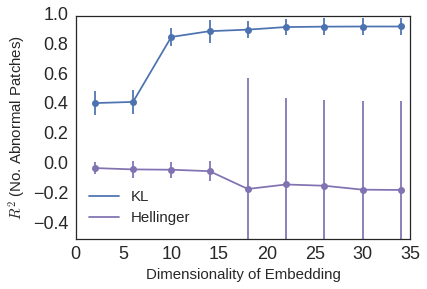

In [18]:
# read in the previously saved data
scoresList = scoresDict['histFHOG_largeRange_setting1']
# psList = psDict['histFHOG_largeRange_setting1']
# len = 21
# keys = SimulatedNNFeats, BOW (50 each for the 50 folds)

# compute average of the 50 folds for score and p value
rAvgUs = np.array([np.mean(scoresList[i]['Ours-KL']) for i in xrange(len(scoresList))])
rAvgBOW = np.array([np.mean(scoresList[i]['BOW']) for i in xrange(len(scoresList))])
rAvgHE = np.array([np.mean(scoresList[i]['Ours-HE']) for i in xrange(len(scoresList))])
rStdUs = np.array([np.std(scoresList[i]['Ours-KL']) for i in xrange(len(scoresList))])
rStdBOW = np.array([np.std(scoresList[i]['BOW']) for i in xrange(len(scoresList))])
rStdHE = np.array([np.std(scoresList[i]['Ours-HE']) for i in xrange(len(scoresList))])
xAxis = np.array([len(colNames) for colNames in colNameList])

# trying stuff with confidence interval
# shortScoresBOW = [scoresList[i]["BOW"] for i in xrange(9)]
# shortScoresUs = [scoresList[i]["Ours-KL"] for i in xrange(9)]
# shortScoresHE = [scoresList[i]["Ours-HE"] for i in xrange(9)]
# ciXBOW, ciYBOW, ciErrBOW = confidenceInterval(colNameList[:9], shortScoresBOW)
# ciXUs, ciYUs, ciErrUs = confidenceInterval(colNameList[:9], shortScoresUs)
# ciXHE, ciYHE, ciErrHE = confidenceInterval(colNameList[:9], shortScoresHE)

#limit the R for HE
# rAvgHE[rAvgHE < 0] = 0.0

import matplotlib.lines as mlines

# plot the average scores
sns.set_style("white") # -- set background white
fig = plt.figure()
# plt.plot(xAxis[:9], rAvgUs[:9], color='b')
# plt.plot(xAxis[:9], rAvgBOW[:9], color='g')
# plt.plot(xAxis[:9], rAvgHE[:9], color='r')
plt.plot(xAxis[:9], rAvgUs[:9], color=sns.color_palette()[0])
plt.plot(xAxis[:9], rAvgHE[:9], color=sns.color_palette()[3])
# plt.title("Cross Validation")
plt.ylabel(r'$R^2$ (No. Abnormal Patches)', fontsize=15)
plt.xlabel("Dimensionality of Embedding", fontsize=15)

# add the error bars
plt.errorbar(xAxis[:9], rAvgUs[:9], rStdUs[:9], fmt='o', color=sns.color_palette()[0], capsize=0)
plt.errorbar(xAxis[:9], rAvgHE[:9], rStdHE[:9], fmt='o', color=sns.color_palette()[3], capsize=0)
# plt.errorbar(xAxis[:9], ciYBOW, yerr=ciErrBOW, fmt='-o', color='b', capsize=0)
# plt.errorbar(xAxis[:9], ciYUs, yerr=ciErrUs, fmt='-o', color='g', capsize=0)
# plt.errorbar(xAxis[:9], ciYHE, yerr=ciErrHE, fmt='-o', color='r', capsize=0)

# add a legend
l1 = mlines.Line2D([], [], color=sns.color_palette()[0], label="KL")
l2 = mlines.Line2D([], [], color=sns.color_palette()[1], label="BOW")
l3 = mlines.Line2D([], [], color=sns.color_palette()[3], label="Hellinger")
l4 = mlines.Line2D([], [], color='w', label="")
plt.legend(handles=[l1, l3], loc=3, fontsize=15)

plt.ylim(-.5, 1.0)

# formatting the plot
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)


# plot the average p values
plt.show()
fig.savefig("simulated-performance-kl-he.pdf", bbox_inches='tight')


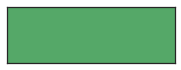

In [15]:
sns.palplot(sns.color_palette()[1])

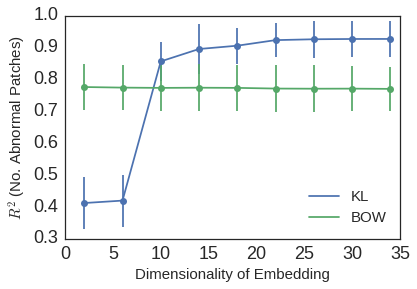

In [17]:
fig = plt.figure()

# scores
plt.plot(xAxis[:9], rAvgUs[:9], color=sns.color_palette()[0])
plt.plot(xAxis[:9], rAvgBOW[:9], color=sns.color_palette()[1])
plt.ylabel(r'$R^2$ (No. Abnormal Patches)', fontsize=15)
plt.xlabel("Dimensionality of Embedding", fontsize=15)
# error bars
plt.errorbar(xAxis[:9], rAvgUs[:9], rStdUs[:9], fmt='o', color=sns.color_palette()[0], capsize=0)
plt.errorbar(xAxis[:9], rAvgBOW[:9], rStdBOW[:9], fmt='o', color=sns.color_palette()[1], capsize=0)
# legend
plt.legend(handles=[l1, l2], loc=4, fontsize=15)
# formatting the plot
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)
plt.show()
fig.savefig("simulated-performance-kl-bow.pdf", bbox_inches='tight')

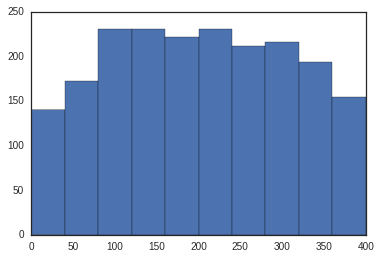

In [87]:
# Figures for Vanathi
# histogram of how many abnormal nodes are present in each subject
fig = plt.figure()
plt.hist(subjClasses)

# allXy = {}    
# yName = 'FEV1pp_utah'

# allXy['SimulatedNNFeats'] = (LLE_modified,subjList)   # is X supposed to be the patch features?
# allXy['BOW'] = (bowized,subjList)    # replaced y with subjList
# print type(allXy['SimulatedNNFeats'][1])
# fig.savefig("hist-sim-classes.pdf", bbox_inches='tight')

In [53]:
print ciYUs

[ 0.76416248  0.76523516  0.76578839  0.76167868  0.76584905  0.74588182
  0.74679851  0.76702733  0.74725483]


In [ ]:
# NOT CORRECT, PRESERVED FOR REFERENCE
# Do the prediction
# set up the regression
X = LLE_modified_KL
y = np.asarray(subjClasses)

# me implementing cross validation 
testSub = []
test = np.random.permutation(len(y))
idx = 0
yPred = np.zeros((len(y)))
useCount = np.zeros((len(y)))
for i in xrange(50):
    # figure out indices for train set
    testSub = test[idx:(idx+len(y)/50)]
    train = [x for x in xrange(len(y)) if x not in testSub]
    useCount[testSub] += 1
    # train the model on the training set
    m = linear_model.Ridge(alpha=1)
    m.fit(X[train], y[train])
    yPred[testSub] = m.predict(X[testSub])
    idx = idx + len(y)/50
    
print "predicted: ", type(yPred), yPred[:10]
print "actual: ", type(y), y[:10]
print useCount.min(), useCount.max()
print "error: ", (y-yPred)[:10]
print "average error: ", np.sum(np.abs(y-yPred))/len(y)

In [ ]:
# set up the regression
X = LLE_modified_KL
y = np.asarray(subjClasses)

cv = KFold(n=len(subjClasses), n_folds=50, shuffle=False, random_state=0)
testPredict = np.zeros((len(y)))

for i, (train, test) in enumerate(cv):
    lr = linear_model.Ridge(alpha=1)
    lr.fit( X[train], y[train] )
    testPredict[test] =  lr.predict(X[test])
    
print "predicted: ", type(testPredict), testPredict[:10]
print "actual: ", type(y), y[:10]

In [ ]:
# save the regression results (prediction)
import h5py

fn = "./simulatedData/interpretation/predictions.hdf5"
with h5py.File(fn, 'w') as hf:
    ds = hf.create_dataset("predictions", [len(testPredict)], compression='gzip', compression_opts=9, data=testPredict)

print "Predictions saved"

In [ ]:
# loading the predictions (for reference)
with h5py.File(fn, 'r') as hf:
    predictions = np.array(hf.get("predictions"))
    
print type(predictions)

In [ ]:
# save kernelKL because oops
kernelFN = "./simulatedData/kernel-kl"
np.savez(kernelFN, similarities=kernelKL)

In [ ]:
loader = np.load(kernelFN+".npz")
kernelLoaded = loader['similarities']
print (kernelLoaded == kernelKL).all()

In [ ]:
print kernelLoaded